<a href="https://colab.research.google.com/github/JohnSWD/ntechlab_tasks/blob/master/ntechlab_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from pathlib import Path
import gc
import os, torch, pickle, time, json
import numpy as np
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, Subset
from typing import Collection, Counter
from google.colab import drive
import torchvision
import torchvision.transforms as transforms
import zipfile
from PIL import Image
import torchvision.models as models
from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AHAlLgIDPYppEX3_6SUnei62pBt61AxWcgVwznvS_o0QzRHxzQFxqM
Mounted at /content/drive/


In [ ]:
# with zipfile.ZipFile(Path('data/male.zip'), 'r') as zip_ref:
#     zip_ref.extractall('data')

In [ ]:
# with zipfile.ZipFile('data/female.zip', 'r') as zip_ref:
#     zip_ref.extractall('data')

In [ ]:
os.chdir('../')

In [ ]:
os.listdir()

['.config', 'drive', 'sample_data']

In [ ]:
!unzip "/content/drive/My Drive/ntechlab/data/male.zip" -d "/content/data"

In [ ]:
!unzip "/content/drive/My Drive/ntechlab/data/female.zip" -d "/content/data"

# Ознакомление с данными

In [ ]:
data_path = Path('data')

In [ ]:
m_pics = data_path.glob('male/*.jpg')
mpics_list = [x for x in m_pics]
f_pics = data_path.glob('female/*.jpg')
fpics_list = [x for x in f_pics]

In [ ]:
m_sample = np.random.choice(mpics_list, 15)
f_sample = np.random.choice(fpics_list, 15)

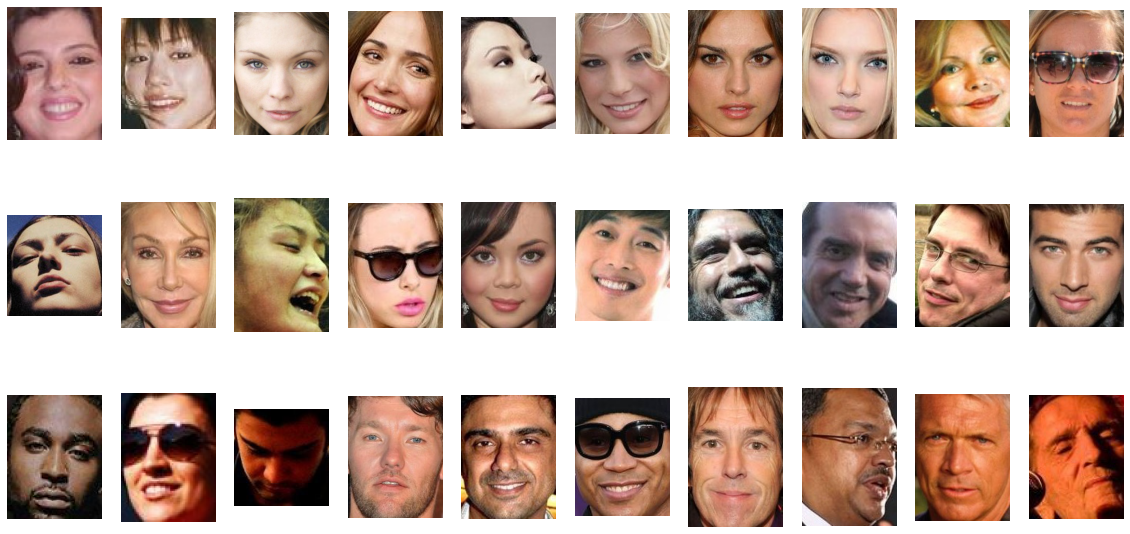

In [ ]:
cols, rows = 3, 10 
plt.figure(figsize=(20,10))
for i, pic in enumerate(np.append(f_sample, m_sample)):
    plt.subplot(cols, rows, i+1)    
    plt.axis('off')
    plt.imshow(Image.open(pic))

Инсайты:
* имеются изображения очень низкого качества
* изображения с надписями
* фотографии сделаны как в профиль, так и сбоку
* лица zoomed in
* изображения разного размера

# Создание датасета, разбиение на обучаующую и валидационную выборки

In [ ]:
mapping = {'male' : 0, 'female' : 1}

class FacesDataset(Dataset):
    def __init__(self, mapping, data_dir = 'data', transform = None, shuffle=True):
        super().__init__()
        self.img_paths = [x for x in Path(data_dir).glob('*/*.jpg')] # массив, содержащий в себе пути ко всем 100002 изображениям
        if shuffle:
          np.random.shuffle(self.img_paths)
        self.transform = transform
        self.mapping = mapping
        
    def __getitem__(self, idx):
        path = self.img_paths[idx]
        img = Image.open(path)
        label = self.mapping[path.parts[1]]
        if self.transform is not None:
            img = self.transform(img)
        return (img, label)
        
    def __len__(self):
        return len(self.img_paths)

In [ ]:
transform_stats = transforms.Compose(
    [transforms.Resize((128, 128)),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor()])

In [ ]:
dataStats = FacesDataset(mapping, transform=transform_stats, shuffle=False)

In [ ]:
# Код в этой клетке взят с форума PyTorch. Вычисляем средние и стандартные отклонения каналов для нормализации
loader = torch.utils.data.DataLoader(dataStats, batch_size=1000, shuffle=False)

mean = 0.
std = 0.
nb_samples = 0.
for data in loader:
    data = data[0]
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

In [ ]:
print(mean, std)

In [ ]:
# ToTensor скэйлит значения в интервал от 0 до 1
transform = transforms.Compose(
    [transforms.Resize((128, 128)),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize([0.6239, 0.4606, 0.3827], [0.2218, 0.1894, 0.1748])])

In [ ]:
fd = FacesDataset(mapping, transform=transform, shuffle=False)

In [ ]:
# для создания сбалансированной валидационной выборки выберем по 5009 случайных изображений каждого класса 
np.random.seed(809) # необходимо, чтобы получались одни и те же индексы (чтобы не пересчитывать среднее и ст. отколонение)

mval_idxs = np.random.choice(np.arange(50001), 5009, replace=False)  # в датасете первые 50001 картинок имеются класс 0
fval_idxs = np.random.choice(np.arange(50001, 100002), 5009, replace=False)
val_idxs = np.append(mval_idxs, fval_idxs) # 10000 картинок в валидационной выборке

In [ ]:
batch_size = 32

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
train = Subset(fd, [x for x in np.arange(100002) if x not in val_idxs])
validation = Subset(fd, val_idxs)

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation, batch_size=batch_size)

In [ ]:
def show_stats(probs: list, labels: list, thr=0.5):
    pred = torch.cat(probs).squeeze()>=thr  # используем порог для присвоения каждому изображению класса
    n = len(pred)
    true = torch.cat(labels)
    tp, fp, tn, fn = 0, 0, 0, 0
    for i in range(n):                      # итерируемся по парам вида (предсказанный класс, истинный класс), чтобы посчитать TP, FP, TN, FN
        if pred[i]==true[i]==1.: 
            tp+=1
        elif pred[i]==true[i]==0.:
            tn+=1
        elif (pred[i]==1) and (true[i]==0):
            fp+=1
        else:
            fn+=1
    if (tp+fp)!=0. and (tp+fn)!=0.:           # считаем метрики precision, recall, F-score
        prec = tp/(tp+fp)
        rec = tp/(tp+fn)
        f1 = 2 * prec * rec / (prec+rec)
    else:
        prec = rec = f1 = -1
    ra_score = roc_auc_score(true.cpu().numpy(), torch.cat(probs).cpu().numpy()) # поскольку датасет сбалансированный можно использовать ROC-AUC вместо PR-AUC
    return f1, ra_score, (tp+tn)/n

# Обучение модели - ResNet

In [ ]:
resnet = models.resnet34()
resnet.fc = nn.Linear(in_features=512, out_features=1, bias=True)

In [ ]:
resnet = resnet.to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(resnet.parameters(),lr=0.0008)

In [ ]:
report_every = 703
epochs = 10
best_val = 0.07

for epoch in range(epochs):                                 # цикл - эпохи
    running_loss = 0.0
    for i, data in enumerate(train_loader):                 # цикл - батчи
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = resnet(inputs)
        loss = criterion(outputs.squeeze(), labels.type_as(outputs))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % report_every == (report_every-1):            # 4 раз за эпоху выводим значения функции поотерь на обучающей и валидационной выборках
            resnet.eval()
            print(f'{i+1}-й батч {epoch + 1}-й эпохи training loss: {running_loss / report_every}')
            running_loss = 0.0
            with torch.no_grad():
                pred, true = [], []
                tot_loss = 0.0
                for batch in validation_loader:             # цикл - батчи (валидация)
                    inputs, labels = batch
                    true.append(labels)
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = resnet(inputs)
                    pred.append(torch.sigmoid(outputs))
                    tot_loss += criterion(outputs.squeeze(), labels.type_as(outputs)).item()
                val_loss = tot_loss / len(validation_loader)

                _, ra_score, _ = show_stats(pred, true)
                print(f'{i+1}-й батч {epoch + 1}-й эпохи validation loss: {val_loss} roc-auc: {ra_score}\n')
                if (best_val > val_loss):                   # сохраняем модель, которая лучше справляется с классификацией изображение на валидации
                    best_val = val_loss
                    torch.save(resnet.state_dict(), f'drive/My Drive/ntechlab/res_{epoch+1}_{str(val_loss)[:6]}.pt')
                    print('Новая модель!\n')
                resnet.train()

In [ ]:
model_state = torch.load('drive/My Drive/ntechlab/res_8_0.0599.pt') # загрузка 

In [ ]:
best = models.resnet34()
best.fc = nn.Linear(in_features=512, out_features=1, bias=True)

In [ ]:
best.load_state_dict(model_state)
best.to(device)
best.eval()

In [ ]:
all = torch.utils.data.DataLoader(fd, batch_size=1000) # интересно было посмотреть на accuracy, посчитанной на всех картинках. Также надо выбрать порог для классификации

with torch.no_grad():
    pred, true = [], []
    tot_loss = 0.0
    for i, batch in enumerate(all):
        inputs, labels = batch
        true.append(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = best(inputs)
        pred.append(torch.sigmoid(outputs))          

In [ ]:
best_acc = 0
best_thr = 0
for thr in np.linspace(0.5, 0.9, 9):    
    f1, ra_score, acc = show_stats(pred, true, thr)
    if acc > best_acc:
        best_acc = acc
        best_thr = thr
    print(f'{thr} - {acc}')

0.5 - 0.9835303293934121
0.55 - 0.9837003259934801
0.6 - 0.9836703265934681
0.65 - 0.9833703325933482
0.7 - 0.9825103497930041
0.75 - 0.9811803763924721
0.8 - 0.9789604207915842
0.8500000000000001 - 0.9757104857902842
0.9 - 0.9701105977880442


# Обучение модели - EfficientNet

In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=438124783f85adad981339c0b2a9ca6bd33fa599e60e7db17aab00004bb19eac
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet

In [ ]:
effnet = EfficientNet.from_name('efficientnet-b3') # у b3 примерно столько же обучаемых параметров, сколько в resnet34
effnet._fc = nn.Linear(in_features=1536, out_features=1, bias=True)

In [ ]:
effnet = effnet.to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(effnet.parameters(),lr=0.0008)

In [ ]:
report_every = 703  # 4 раза за эпоху
epochs = 10
best_val = 0.06
lr = 0.0008

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = effnet(inputs)
        loss = criterion(outputs.squeeze(), labels.type_as(outputs))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % report_every == (report_every-1):
            effnet.eval()
            print(f'{i+1}-й батч {epoch + 1}-й эпохи training loss: {running_loss / report_every}')
            running_loss = 0.0
            with torch.no_grad():
                pred, true = [], []
                tot_loss = 0.0
                for batch in validation_loader:
                    inputs, labels = batch
                    true.append(labels)
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = effnet(inputs)
                    pred.append(torch.sigmoid(outputs))
                    tot_loss += criterion(outputs.squeeze(), labels.type_as(outputs)).item()
                val_loss = tot_loss / len(validation_loader)

                _, ra_score, _ = show_stats(pred, true)
                print(f'{i+1}-й батч {epoch + 1}-й эпохи validation loss: {val_loss} roc-auc: {ra_score}\n')
                if (best_val > val_loss) and (ra_score>=0.996):
                    best_val = val_loss
                    torch.save(effnet.state_dict(), f'drive/My Drive/ntechlab/eff_{epoch+1}_{str(val_loss)[:6]}.pt')
                    print('Новая модель!')
            effnet.train()

703-й батч 1-й эпохи training loss: 0.3751408453993658
703-й батч 1-й эпохи validation loss: 0.2346396047805857 roc-auc: 0.974639460111747

1406-й батч 1-й эпохи training loss: 0.1839012469709513
1406-й батч 1-й эпохи validation loss: 0.134027748015727 roc-auc: 0.9892755627213797

2109-й батч 1-й эпохи training loss: 0.14827560208695456
2109-й батч 1-й эпохи validation loss: 0.1323159716318578 roc-auc: 0.9921644732832866

2812-й батч 1-й эпохи training loss: 0.12195074283498025
2812-й батч 1-й эпохи validation loss: 0.15140871728177607 roc-auc: 0.991647276866105

703-й батч 2-й эпохи training loss: 0.1071336320502045
703-й батч 2-й эпохи validation loss: 0.11008894836029022 roc-auc: 0.9944536647769291

1406-й батч 2-й эпохи training loss: 0.10564030836048836
1406-й батч 2-й эпохи validation loss: 0.10045522417959157 roc-auc: 0.9949914470184453

2109-й батч 2-й эпохи training loss: 0.10327712586613247
2109-й батч 2-й эпохи validation loss: 0.10080439583279761 roc-auc: 0.9943521904134148

In [ ]:
effnet = EfficientNet.from_name('efficientnet-b3')
effnet._fc = nn.Linear(in_features=1536, out_features=1, bias=True)

In [ ]:
state = torch.load('drive/My Drive/ntechlab/eff_9_0.0573.pt')
effnet.load_state_dict(state)
effnet.to(device)
effnet.eval()

In [ ]:
all = torch.utils.data.DataLoader(fd, batch_size=1000) # интересно было посмотреть на accuracy, посчитанной на всех картинках. Также надо выбрать порог для классификации

In [ ]:
with torch.no_grad():
    pred, true = [], []
    tot_loss = 0.0
    for i, batch in enumerate(all):
        inputs, labels = batch
        true.append(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = effnet(inputs)
        pred.append(torch.sigmoid(outputs))      

In [ ]:
best_acc = 0
best_thr = 0
for thr in np.linspace(0.3, 0.8, 11):    
    f1, ra_score, acc = show_stats(pred, true, thr) 
    if acc > best_acc:
        best_acc = acc
        best_thr = thr
    print(f'{thr} - {acc} - {f1}')
print(ra_score)

In [ ]:
best_thr

0.4